## 1. Import all packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob, time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

## 2. Load images

In [4]:
images = glob.glob('training_images/*/*/*')

cars = []
noncars = []
for image in images:
    if 'non' in image:
        noncars.append(image)
    else:
        cars.append(image)

cars = list(map(lambda img: mpimg.imread(img), cars))
noncars = list(map(lambda img: mpimg.imread(img), noncars))


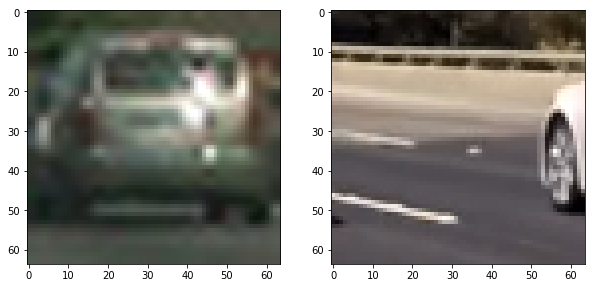

In [8]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(cars[0])
plt.subplot(122)
plt.imshow(noncars[4])

## 3. Feature extraction

In [9]:
def bin_spatial(img, size=(32, 32)):
    """
    Create a feature vector of the image
    """
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Returns the feature vector of color histograms
    """
    c1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
    return hist_features

def extract_hog_features(img, orientations, pixels_per_cell, cells_per_block):
    """
    Get feature vector and hog image
    """
    features, hog_image = hog(img, orientations=orientations, 
                                  pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block), 
                                  transform_sqrt=True, 
                                  visualise=True, feature_vector=True)
    return features, hog_image

/home/sree/Programs/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


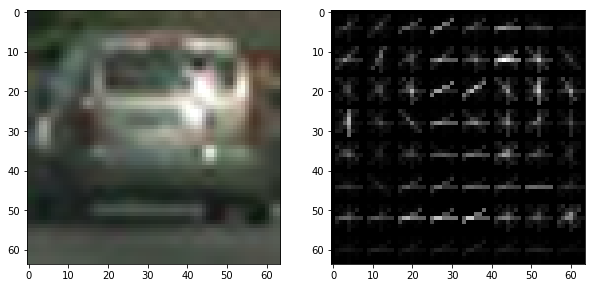

In [10]:
features, hog_image = extract_hog_features(car_img[:,:,0], 8, 8, 2)

plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(car_img)
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')

In [11]:
def extract_features(image, color_space='YCrCb', orientation=8, pix_per_cell=8, cell_per_block=2, 
                     size=(16,16), hist_bins = 32, hist_range=(0,256), hog_channel='ALL'):

    """
    Feature extraction pipeline
    """
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            features, _ = extract_hog_features(feature_image[:,:,channel], 
                                orientation, pix_per_cell, cell_per_block)
            hog_features.append(features)
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orientation, 
                    pix_per_cell, cell_per_block)

    # get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # get color histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))


def fit_model(positives, negatives, svc, scalar):
    """
    Fit an SVM model
    """
    positive_features = list(map(lambda img: extract_features(img), positives))
    negative_features = list(map(lambda img: extract_features(img), negatives))
    
    X = np.vstack((positive_features, negative_features)).astype(np.float64)    
    X_scaler = scaler.fit(X)
    X_scaled = X_scaler.transform(X)

    y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negative_features))))
    
    # test train split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=43)
    
    # Fitting
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    fittingTime = round(t2 - t, 2)
    accuracy = round(svc.score(X_test, y_test),4)
    return (svc, X_scaler, fittingTime, accuracy)

In [ ]:
svc, scaler, fittingTime, accuracy = fit_model(cars, noncars, LinearSVC(), StandardScaler())
print('Fitting time: {} s, Accuracy: {}'.format(fittingTime, accuracy))

/home/sree/Programs/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
